# MonaLIA Pair-Wise Odds Ratio between categories (DL training set) 
Experiment to explore whether a probability of appearance of one concept of a context-similar pair can improve the probability score of the second concept in the same image. For example, if a high classification probability score for a bateau could influence the score of the category mer. To achieve this, we used a logistic regression approach. 

The idea is to build a pairwise regression predictor of appearance of the category A of a pair (A, B) based on the presence of category B in the Joconde dataset metadata. Both dependent variable (category A) and predictor (category B) are binary labels. The regression estimates the log-odds of observing category A when category B is present compared to situations when category B is not present. 

$$log (odds(A))  = β_0+ β_1*B, where β_1=log (\frac{odds(A|B)}{odds(A no B)})$$
 
These estimates are dependent on the dataset. If a different dataset is used it might lead to a different value of β1. Binary indicator model compares situations when category B is present or not. But because machine learning models predict categories with continuous probability scores S(A) and S(B), we want to reuse the regression parameters to predict an adjustment of probability score of category A of pair (A, B) based on a difference of probability score of category B compared to a baseline P(B)base that category B is present.

$$log (odds(A)_{adj} )  = β_0+ β_1*(S(B) - P(B)_{base} ),$$

where $S(B)$ is a classification prediction score of B. $P(B)_{base}$ can be calculated as a frequency of this category in the dataset. Thus, we consider how much the prediction score for B is higher (or lower) than the one obtained purely by chance. For the Joconde dataset we estimated P(B)base by direct counting of concepts in the annotations in the training set (to be noticed, that the training set is better balanced than the entire dataset).

We assume that an unadjusted estimate of $S(A)$ corresponds to the baseline probability $P(B)_{base}$ and the adjustment could be made by using the actual prediction score $S(B)$. The adjusted odds of A thus become:

$$odds(A)_{adj}= \frac{S(A)}{1-S(A)} * e^{β_1*(S(B)-P(B)_{base} ) }$$

In case of $S(B) = P(B)_{base}$, there will be no adjustments to the score.  This approach also considers that when the score of label B is lower than the average, it will reduce the probability of label A. This approach might impact recall and precision not symmetrically which can lead to subjective decisions. 

For example, the presence of a boat often implies some body of water, however the sea might be present on a painting without any boat. We thus considered an additional threshold for the lower values of $P(B)_{base}$, below which we do not consider adjustments. This modification will adjust the prediction score of category A when the label B is present and will leave $S(A)$ unadjusted when $P(B)_{base}$ is low.

Method of adjusting the probability scores of category A in the context-bases pair (A, B) and evaluated the adjustments on the test set:

    1. Estimate the odds ratio from a logistic regression on the metadata of the dataset 
    2. Estimate the baseline probability for category B on the same data
    3. Calculate the adjusted prediction score for category A from the estimated odd ratio coefficient and the difference between the estimated baseline and prediction score for category B. 
    4. Evaluate the adjusted prediction using standard metrics


#### This notebook reqires SPARQL engine with Joconde dataset and model obtained prediction scores RDF loaded


Prediction scores obtained by SPARQL query assuming that the scores are already in the KB dataset

In [1]:
from __future__ import print_function

import os
import sys

import numpy as np
import pandas as pd

import SPARQLWrapper

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm
from sklearn import metrics

from IPython.display import display, HTML
from  textwrap import wrap

In [2]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
from MonaLIA.util import metadata_helpers as metadata
from MonaLIA.util import visualization_helpers as vis_helpers

importlib.reload(metadata)
importlib.reload(vis_helpers)

<module 'MonaLIA.util.visualization_helpers' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\MonaLIA\\util\\visualization_helpers.py'>

In [7]:
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)
print('Pandas ver.', pd.__version__)

SPARQLWrapper ver. 1.8.5
Pandas ver. 1.0.1


In [8]:
wds_Joconde_Corese = 'http://localhost:8080/sparql'

## Query annotations

In [9]:
descr_path = 'C:/Datasets/Joconde/Forty classes'
dataset_description_file = os.path.join(descr_path, 'dataset1.csv')

annotations_df = pd.read_csv(dataset_description_file, na_filter=False)
print(annotations_df.shape)
annotations_df.head()

(85797, 12)


,Unnamed: 0,label,repr,imagePath,ref,term_count,top_term_count,terms,domain,width,height,usage
0,0,bateau,"paysage (canal, village, passerelle, barque, p...",/0093/m503501_d0109897-000_p.jpg,50350109897,1,1,barque,dessin,768,512,train
1,1,arbre+maison,"vue d'architecture (arbre, place, maison, Cour...",/0650/m080901_031011_p.jpg,M0809027797,2,2,arbre+maison,dessin,696,600,test
2,2,en buste,"portrait (Henri III, roi de Pologne, roi de Fr...",/0662/m501702_0006031_p.jpg,50170000659,1,1,en buste,estampe ; histoire,432,600,remain
3,3,nu,"figure (femme, nu, debout)",/0506/m504401_d-3861_p.jpg,50440002374,1,1,nu,dessin,266,600,remain
4,4,maison,"vue d'architecture (Angers, ville, maison, jar...",/0624/m074801_0010663_p.jpg,07480014655,1,1,maison,dessin,800,561,train


In [10]:
def my_tokenizer(s):
    return list(filter(None, set(s.split('+'))))

annotations_df.label = annotations_df.label.apply(my_tokenizer)

In [11]:
annotations_df.shape

(85797, 12)

## Create indicators columns

In [12]:
train_annotations_df = annotations_df.loc[annotations_df.usage == 'train']

annotations_dummies_df = pd.get_dummies(train_annotations_df.explode('label').label).groupby(level=0).sum()
annotations_dummies_df.columns = annotations_dummies_df.columns.str.replace(' ', '_')
annotations_dummies_df.head()

,ange,arbre,armure,bateau,bateau_à_voiles,casque,cavalier,chapeau,cheval,chien,...,oiseau,pont,robe,table,tour,uniforme,voiture_à_attelage,à_mi-corps,église,épée
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
train_annotations_df = train_annotations_df.merge(annotations_dummies_df,
                                      left_index=True,
                                      right_index=True)
print(annotations_df.shape)

(85797, 12)


In [14]:
corr_df = annotations_dummies_df.corr()

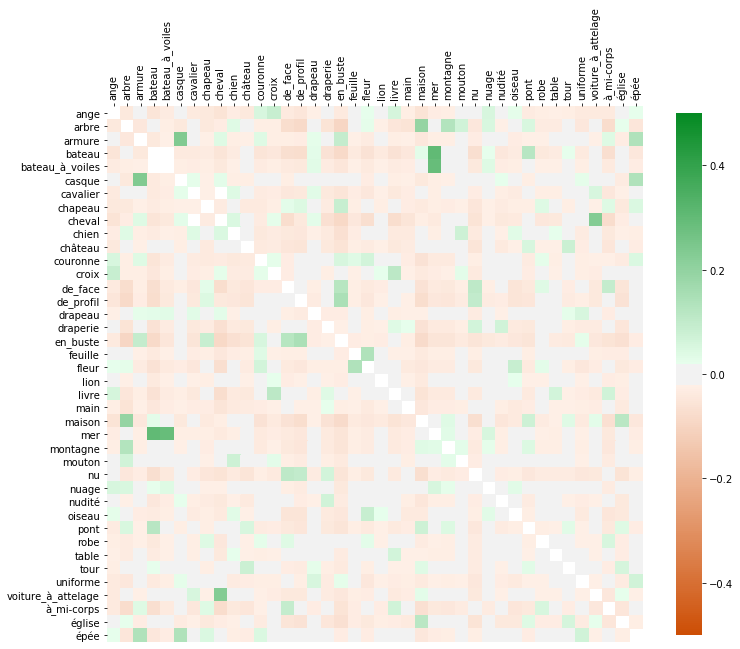

In [15]:
fig=plt.figure(figsize=(12, 12))

cmap_div = sns.diverging_palette(22, 130, s=99, n=16, as_cmap=True)

mask = corr_df >= 0.5

ax = sns.heatmap(corr_df , cmap=cmap_div,
                 mask = mask,
                 vmin=-0.5, vmax=0.5 , center =0.0,
                 square=True, cbar_kws={"shrink": 0.8})

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_ticks_position('top')

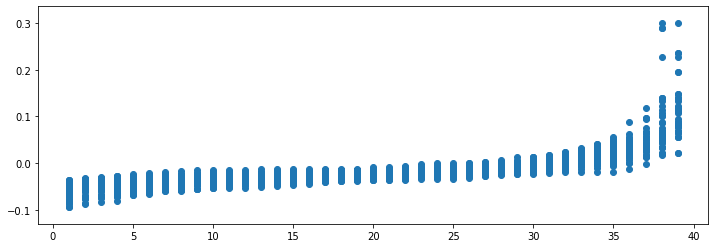

In [16]:
fig=plt.figure(figsize=(12, 4))

plt.scatter(x = corr_df[corr_df < 0.5].rank(),
            y = corr_df[corr_df < 0.5])

In [17]:
top_corr_df = corr_df.stack().reset_index()
top_corr_df.columns = ['label_A', 'label_B', 'cor']

top_corr_df = top_corr_df[(top_corr_df.cor > 0.1) & (top_corr_df.cor < 0.5)]

print(top_corr_df.shape)
top_corr_df.sort_values(by='cor', ascending=False)

(32, 3)


,label_A,label_B,cor
144,bateau,mer,0.300788
963,mer,bateau,0.300788
964,mer,bateau_à_voiles,0.289498
184,bateau_à_voiles,mer,0.289498
85,armure,casque,0.236028
202,casque,armure,0.236028
1448,voiture_à_attelage,cheval,0.228046
356,cheval,voiture_à_attelage,0.228046
63,arbre,maison,0.194454
921,maison,arbre,0.194454


In [353]:
label_A = 'mer'#'cheval'#, 'mer'
label_B = 'bateau' #'voiture à attelage'#'bateau'

label_A_ = label_A.replace(' ', '_')
label_B_ = label_B.replace(' ', '_')

In [354]:
from collections import namedtuple
Label_Stats = namedtuple('Label_Stats', ['Probs', 'Joint_prob', 'Cond_probs', 
                                         'Variance', 'Odds', 
                                         'Covariance', 'Correlation', 
                                         'PWOR'])

def calculate_stats (df, label_A, label_B, prnt=False):

    p_A = df[label_A].sum() / df.shape[0]
    p_B = df[label_B].sum() / df.shape[0]
    p_AB = (df[[label_A, label_B]].sum(axis=1) == 2).sum() / df.shape[0]
    p_A_given_B = p_AB / p_B
    p_B_given_A = p_AB / p_A

    var_A = p_A * (1-p_A)
    var_B = p_B * (1-p_B)

    odds_A = p_A /(1 - p_A)
    odds_B = p_B /(1 - p_B)

    cov_AB = p_AB - p_A*p_B
    cor_AB = cov_AB / ( np.sqrt(var_A) * np.sqrt(var_B) )
    
    pwor_AB = odds_A * ((1 - p_B_given_A) / p_B_given_A)
    pwor_BA = odds_B * ((1 - p_A_given_B) / p_A_given_B)
    
 
    if (prnt):

        print('count(%s) = %d' % ( label_A, df[label_A].sum()) )
        print('count(%s) = %d' % ( label_B, df[label_B].sum()) )
        print()
        print('P(%s) = %f' % (label_A, p_A))
        print('P(%s) = %f' % (label_B, p_B))
        print('P(%s,%s) = %f' % (label_A, label_B, p_AB))
        print()
        print('P(%s|%s) = %f' % (label_A, label_B, p_A_given_B))
        print('P(%s|%s) = %f' % (label_B, label_A, p_B_given_A))
        print()
        print('Odds(%s) = %f' % (label_A, odds_A))
        print('Odds(%s) = %f' % (label_B, odds_B))
        print()
        print('Var(%s) = %f' % (label_A, var_A))
        print('Var(%s) = %f' % (label_B, var_B))
        print()
        print('Cov(%s,%s) = %f' % (label_A, label_B, cov_AB))
        print()
        print('Cor(%s,%s) = %f' % (label_A, label_B, cor_AB))
        print()
        print('PWOR(%s|%s) = %f' % (label_A, label_B, pwor_AB))        
        print('PWOR(%s|%s) = %f' % (label_B, label_A, pwor_BA))        
        

    stats = Label_Stats( (p_A, p_B), p_AB, (p_A_given_B, p_B_given_A), (var_A, var_B), (odds_A, odds_B), cov_AB, cor_AB,
                        (pwor_AB, pwor_BA))
    return stats

stats = calculate_stats(train_annotations_df, label_A_, label_B_, prnt=True)

count(mer) = 1726
count(bateau) = 4356

P(mer) = 0.030827
P(bateau) = 0.077800
P(mer,bateau) = 0.016324

P(mer|bateau) = 0.209826
P(bateau|mer) = 0.529548

Odds(mer) = 0.031807
Odds(bateau) = 0.084363

Var(mer) = 0.029877
Var(bateau) = 0.071747

Cov(mer,bateau) = 0.013926

Cor(mer,bateau) = 0.300788

PWOR(mer|bateau) = 0.028258
PWOR(bateau|mer) = 0.317700


In [355]:
formula = '%s ~ %s' % (label_A_, label_B_)

res = sm.formula.glm(formula,  family=sm.families.Binomial(), data=train_annotations_df).fit() 
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mer   No. Observations:                55990
Model:                            GLM   Df Residuals:                    55988
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6415.1
Date:                Wed, 19 Aug 2020   Deviance:                       12830.
Time:                        15:08:11   Pearson chi2:                 5.60e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1366      0.035   -116.944      0.0

### Extract test set data drom the annotations

In [356]:
test_annotations_df = annotations_df.loc[annotations_df.usage == 'test']

test_annotations_dummies_df = pd.get_dummies(test_annotations_df.explode('label').label).groupby(level=0).sum()
test_annotations_dummies_df.columns = annotations_dummies_df.columns.str.replace(' ', '_')

test_annotations_df = test_annotations_df.merge(test_annotations_dummies_df,
                                                  left_index=True,
                                                  right_index=True)
test_annotations_df.shape


(4463, 52)

### Read scores from the KB for the test set

In [357]:
query_image_for_test_set = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select ?ref
       ?imageURL
       ?title
       ?repr
       #?target_labels
       #?actual_labels
       ?classifier_label
       ?score
       
where 
{
    VALUES(?ref) {("%s")}

   
    ?notice jcl:noticeRef ?ref;
            jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImageUrl ?imageURL].        

    optional {?notice jcl:noticeTitr  ?title.}
    optional {?notice jcl:noticeRepr  ?repr.}
     
    
    {
       select *
       where {
       
        VALUES (?classifier_label) { ("%s"@fr) ("%s"@fr) }  
    
        ?classifierCategory a jcl:Term;
                    skos:prefLabel ?classifier_label;
                    skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>.
        
        ?classifier rdfs:label "40_classes".

        ?notice ml:imageClassifier [a ?classifier ;
                                    ml:detected [ a ?classifierCategory ;
                                                  ml:score ?score ]].

    }
   }
}

''' #% (test_annotations_df.ref[:100].str.cat(sep = ' ' ).replace(' ', '") ("'), label_A, label_B )

In [358]:
#%time test_ext_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_image_for_test_set)
#print(test_ext_df.shape)

In [359]:
chunk_size = 100
ref_chunk_list = [test_annotations_df.ref[i:i+chunk_size] for i in range(0,test_annotations_df.ref.size, chunk_size)]

test_df = pd.DataFrame()
    
for i, ref_chunk in enumerate(ref_chunk_list):
    print(ref_chunk.size * (i+1), end=', ')
    
    chunk_query_str = query_image_for_test_set %  (ref_chunk.str.cat(sep = ' ' ).replace(' ', '") ("') , label_A, label_B)
    
    test_df = pd.concat([test_df, metadata.sparql_service_to_dataframe(wds_Joconde_Corese, chunk_query_str)], ignore_index=True)
    
print('Done')   

100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 2835, Done


In [360]:
def agg_scores(x):
    _x = x#.sort_values(by='classifier_label' , ascending=True, inplace=False) 

    return pd.Series(dict(#targets = _x.iloc[0].target_labels,
                          pred_dict = dict(zip(_x['classifier_label'], _x['score'].astype(float))) 
                          #predictions = list(_x['classifier_label']),
                          #scores = list(_x['score'])
                         ))

def adjust_scores(logit_res, score_A, score_B, base_prob_B = 0.5 ):
    score_A = score_A - 0.0000001 # to prevent division by 0 for score = 1.0
    odds_pred_A = score_A / (1-score_A)
    
    pwor_A_given_B = np.exp(logit_res.params[1] * (score_B - base_prob_B))
    
    odds_pred_A_new = odds_pred_A * pwor_A_given_B
    
    score_A_new = odds_pred_A_new / (1+ odds_pred_A_new)
    
    return score_A_new

def adjust_scores_with_th(logit_res, score_A, score_B, base_prob_B = 0.5, th=0.5 ):
    score_A = score_A - 0.0000001  # to prevent division by 0 for score = 1.0
    odds_pred_A = score_A / (1-score_A)
    if (score_B > th): 
        pwor_A_given_B = np.exp(logit_res.params[1] * (score_B - base_prob_B))

        odds_pred_A_new = odds_pred_A * pwor_A_given_B

        score_A_new = odds_pred_A_new / (1+ odds_pred_A_new)
    else:
        score_A_new = score_A
    
    return score_A_new


test_df_ = test_df.groupby('ref') \
                   .apply(agg_scores) \
                   .reset_index() \
                   .set_index('ref')

test_df_['adjusted_score_'+label_A] = test_df_.apply(lambda x: adjust_scores_with_th(res,
                                                                      x.pred_dict[label_A],
                                                                      x.pred_dict[label_B],
                                                                       base_prob_B=0.85,
                                                                       th=0.5), axis=1 )
test_df_  = test_df_.merge(test_annotations_df.set_index('ref').loc[:, [label_A_, label_B_]] ,
                           left_index=True,
                           right_index=True) 
print(test_df_.shape)
test_df_.head()


(4463, 4)


,pred_dict,adjusted_score_mer,mer,bateau
ref,,,,
00000055186,"{'mer': 0.0012, 'bateau': 0.0027}",0.0012,0,0
00000055213,"{'mer': 0.0009, 'bateau': 0.0008}",0.0009,0,0
00000055422,"{'mer': 0.0093, 'bateau': 0.0124}",0.0093,0,0
00000055473,"{'mer': 0.0008, 'bateau': 0.0052}",0.0008,0,0
00000055751,"{'mer': 0.2092, 'bateau': 0.4129}",0.2092,0,0


In [361]:
y_true = np.array(test_df_.loc[:, [label_A_, label_B_]] , dtype = np.dtype('B')) 
y_scores =  pd.DataFrame.from_dict({label_A: test_df_.pred_dict.apply(lambda x: x[label_A]),
                                    label_B: test_df_.pred_dict.apply(lambda x: x[label_B])}).to_numpy()

AP =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores,
                                      average= None)
print('original AP', dict(zip([label_A, label_B], AP)))



y_scores_adj =  pd.DataFrame.from_dict({label_A: test_df_['adjusted_score_'+label_A],
                                    label_B: test_df_.pred_dict.apply(lambda x: x[label_B])}).to_numpy()


AP_adj =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores_adj,
                                      average= None)
print('adjusted AP', dict(zip([label_A, label_B], AP_adj)))

original AP {'mer': 0.5402827142790179, 'bateau': 0.7775147489020647}
adjusted AP {'mer': 0.5323760216716331, 'bateau': 0.7775147489020647}


Text(0.5, 1.0, ' Precision-Recall curve: bateau AP=0.78')

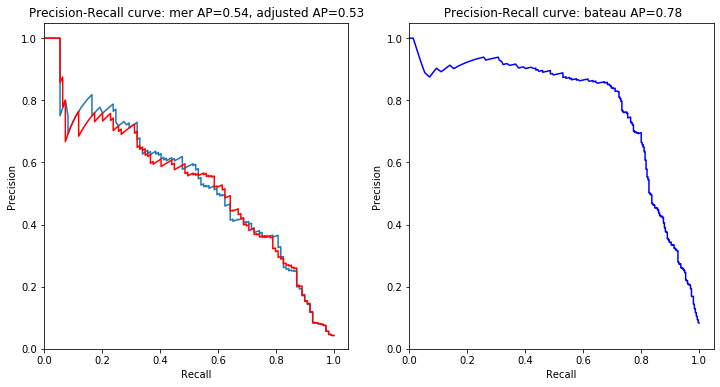

In [362]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((12,6))

precision_A, recall_A, th = metrics.precision_recall_curve(y_true[:, 0],
                                                          y_scores[:, 0])

ax1.plot(recall_A, precision_A)

precision_A_adj, recall_A_adj, _ = metrics.precision_recall_curve(y_true[:, 0],
                                                          y_scores_adj[:, 0])

ax1.plot(recall_A_adj, precision_A_adj, color='red')
ax1.set_xlim(0.0, 1.05)
ax1.set_ylim(0.0, 1.05)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall curve: {0} AP={1:0.2f}, adjusted AP={2:0.2f}'.format(label_A, AP[0], AP_adj[0]))

precision_B, recall_B, _ = metrics.precision_recall_curve(y_true[:, 1],
                                                          y_scores[:, 1])

ax2.plot(recall_B, precision_B, color='b')
#ax2.fill_between(recall_B, precision_B, alpha=0.2, color='b', step='post')
ax2.set_xlim(0.0, 1.05)
ax2.set_ylim(0.0, 1.05)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(' Precision-Recall curve: {0} AP={1:0.2f}'.format(label_B, AP[1]))

In [363]:
threshold_A =  0.9
threshold_B = 0.85

y_pred = (y_scores > np.array([threshold_A, threshold_B])).astype(dtype = np.dtype('B'))

report = metrics.classification_report(y_true= y_true,
                                         y_pred= y_pred, 
                                         target_names = [label_A, label_B])

#print(report)

print()

y_pred_adj = (y_scores_adj > np.array([threshold_A, threshold_B])).astype(dtype = np.dtype('B'))

report_adj = metrics.classification_report(y_true= y_true,
                                         y_pred= y_pred_adj, 
                                         target_names = [label_A, label_B])

#print(report_adj)

C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


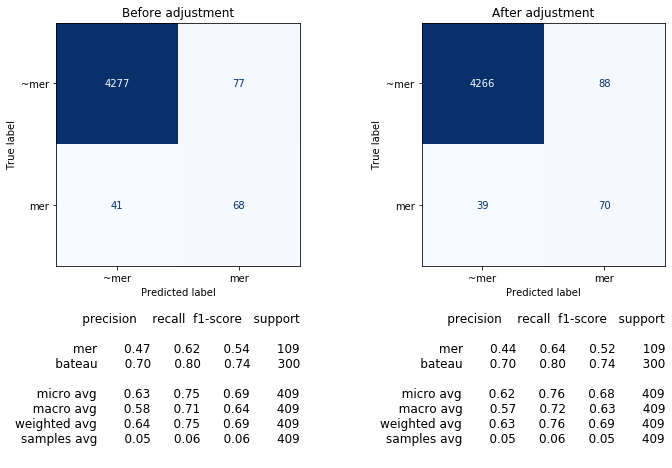

In [364]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((12,8))

cm = metrics.multilabel_confusion_matrix(y_true, y_pred)
metrics.ConfusionMatrixDisplay(cm[0], display_labels=['~' + label_A, label_A]).plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title('Before adjustment')
ax1.text(1.5, 3.1, report, horizontalalignment='right', verticalalignment='bottom', fontsize=12)

cm_adj = metrics.multilabel_confusion_matrix(y_true, y_pred_adj)
metrics.ConfusionMatrixDisplay(cm_adj[0], display_labels=['~' + label_A, label_A,]).plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('After adjustment')
ax2.text(1.5, 3.1, report_adj, horizontalalignment='right', verticalalignment='bottom', fontsize=12)

plt.delaxes(fig.axes[2])
plt.delaxes(fig.axes[2])


In [365]:
def gather_row_annotation(row):
    return '\n'.join( wrap(row.title, 30 ) + 
                     [''] + 
                    wrap(row.repr, 30 ) +
                    ['',
                     '<a target="_blank" href="https://www.pop.culture.gouv.fr/notice/joconde/%s">%s</a>' % (row.ref, row.ref),
                     #'',
                    # row.imagePath
                    ])

def aggregate_group_by(x):
    _x = x#.sort_values(by='classifier_label' , ascending=True, inplace=False) 

    return pd.Series(dict(imageURL = _x.iloc[0].imageURL, 
                          info = gather_row_annotation(_x.iloc[0]), 
                          actuals=  _x.iloc[0]['actual_labels'].replace('+', '\n'),
                          targets=  _x.iloc[0]['target_labels'].replace('+', '\n'),
                          predictions = '\n'.join(_x['classifier_label']),
                          scores = '\n'.join(_x['score'])
                         ))

formatters_dict={'imageURL': vis_helpers.image_url_formatter,
                 'info': vis_helpers.label_formatter, 
                 'repr': vis_helpers.repr_formatter,
                 'predictions': vis_helpers.label_formatter,
                 'classifier_label':  vis_helpers.label_formatter,
                 'scores':  vis_helpers.label_formatter,
                 'actuals':  vis_helpers.label_formatter,
                 'targets':  vis_helpers.label_formatter}


In [366]:
test_view_df = test_df.set_index('ref') \
                      .merge(test_annotations_df.set_index('ref').loc[:, ['label', 'terms']] ,
                             left_index=True,
                             right_index=True) \
                      .reset_index()

test_view_df.rename( columns={'label': 'target_labels', 
                              'terms': 'actual_labels'}, inplace=True)

test_view_df.target_labels = test_view_df.target_labels.apply(lambda x: '+'.join(x))

In [367]:
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center') 
pd.set_option('precision', 4)

test_view_df.fillna('', inplace=True)

print(test_view_df.groupby('ref').size().shape)
print('Sample of 20 images that annotated with either "%s" or "%s"' % (label_A, label_B )  )

HTML(test_view_df.groupby('ref') \
                   .apply(aggregate_group_by) \
                   .reset_index() \
                   .set_index('ref') \
                   .merge(test_df_.loc[(test_df_[label_A] + test_df_[label_B]) > 0 , ['adjusted_score_'+label_A]], left_index=True, right_index=True)[:20] \
                   .to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False))

(4463,)
Sample of 20 images that annotated with either "mer" or "bateau"


imageURL,info,actuals,targets,predictions,scores,adjusted_score_mer
,"VUE D'ARICIApaysage (rivière, bateau,personnage, ville)00000061444",bateau,bateau,merbateau,0.75250.9907,0.8187
,"GROUPE DE PECHEURS ASSIS SURLA PLAGE ENTRE DEUX BARQUES AL'OMBRE D'UNE VOILEscène (pêcheur : Italien,assis, bateau à voiles, plage)00000069357",bateau à voilesbateau à voiles,bateaubateau à voiles,merbateau,0.99050.9994,0.9937
,"LE MARIN ; HEROISME ; LESNAUFRAGESscène (naufrage, tempête,vague, jetée, marin, homme,femme, vieux, béquille,barque, secours, héroïsme)00000074619",barque,bateau,merbateau,0.11690.2543,0.1169
,"PAYSAGE, LE PRINTEMPSpaysage (feuillu, maison,nappe d'eau, printemps) ;barque ; personnage00000074824",feuillubarquemaison,arbremaisonbateau,merbateau,0.00280.8828,0.0031
,"HALLALI DU CERF AUX ETANGS DECOMMELLEscène (chasse à courre, étang,chien, cerf, barque)00000076515",barquechien,chienbateau,merbateau,0.03940.1011,0.0394
,"VILLE HOLLANDAISE AU BORD DEL'EAUpaysage (ville, Hollande,bateau à voiles, port, ?,nuage)00000081502",bateau à voilesbateau à voilesnuage,nuagebateaubateau à voiles,merbateau,0.47420.9981,0.5776
,"PORTO D'ANZIO, COQUES SUR LAPLAGEpaysage (Porto d'Anzio, plage,bateau à voiles)00000091272",bateau à voilesbateau à voiles,bateaubateau à voiles,merbateau,0.86090.7749,0.8336
,"QUATRE PECHEURS PRES DE LEURBARQUEscène (Italie, pêcheur, assis,plage, bateau à voiles)00000091280",bateau à voilesbateau à voiles,bateaubateau à voiles,merbateau,0.98850.9985,0.9924
,"PAYSAGE AVEC FIGURES, BORDD'UNE RIVIEREpaysage (rivière, chaumière,tour fortifiée, feuillu, ciel); barque ; personnage00000094599",feuillubarque,arbrebateau,merbateau,0.4290.9932,0.5291
,"Un havre pour les petitsbateaux [titre attribué]paysage (port, bateau àvoiles, marin pêcheur,Côtes-d'Armor d, [sl])00000097902",bateau à voilesbateau à voiles,bateaubateau à voiles,merbateau,0.68390.9994,0.7670


In [351]:
test_view_df_flipped = test_view_df.set_index('ref') \
                                    .merge(test_annotations_df.set_index('ref').loc[:, [label_A]] ,
                                             left_index=True,
                                             right_index=True) \
                                    .merge(test_df_.loc[: , ['pred_dict', 'adjusted_score_'+label_A]],
                                             left_index=True,
                                             right_index=True) \
                                    .reset_index() 
test_view_df_flipped[label_A+'_p'] = test_view_df_flipped.pred_dict.apply(lambda x: 1 if x[label_A] > threshold_A else 0)
test_view_df_flipped[label_A+'_ap'] = test_view_df_flipped['adjusted_score_'+label_A].apply(lambda x: 1 if x > threshold_A else 0)


print('Changed classification for "%s"' % (label_A)  )
test_view_df_flipped = test_view_df_flipped.loc[ test_view_df_flipped[label_A+'_p'] != test_view_df_flipped[label_A+'_ap'], :]

#print('Classification False Positives for "%s"' % (label_A)  )
#test_view_df_flipped = test_view_df_flipped.loc[ (test_view_df_flipped[label_A] == 0) & (test_view_df_flipped[label_A+'_p'] == 1), :]


Changed classification for "chien"


In [352]:
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center') 
pd.set_option('precision', 4)

test_view_df_flipped.fillna('', inplace=True)

print(test_view_df_flipped.groupby('ref').size().shape)
HTML(test_view_df_flipped.groupby('ref') \
                   .apply(aggregate_group_by) \
                   .reset_index() \
                   .set_index('ref') \
                   #.merge(test_df_.loc[:, ['adjusted_score_A']], left_index=True, right_index=True) \
                   .merge(test_view_df_flipped.loc[:, ['ref', 'adjusted_score_'+label_A, label_A, label_A+'_p', label_A+'_ap']].set_index('ref'), left_index=True, right_index=True) \
                   .drop_duplicates() \
                   .sort_values(by=[label_A, label_A+'_p', label_A+'_ap'])
                   .to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False, 
                        show_dimensions=True))

(3,)


imageURL,info,actuals,targets,predictions,scores,adjusted_score_chien,chien,chien_p,chien_ap
,"Course camarguaisescène (Vauvert, place, foule :spectateur, homme, taureau,tauromachie, divertissement,charrette, barrière, maison)M0903001165",maisoncharrette,voiture à attelagemaison,chiencheval,0.8930.9994,0.9013,0,0,1
,"Histoire grecque (08) : mortde Xante (titre inscrit)scène (duel, cavalier, soldat,guerre)02110008532",cavaliercavalier,cavaliercheval,chiencheval,0.90670.5033,0.8874,0,1,0
,"Cimabue et Giotto (Intituléincertain)scène (Cimabue, Giotto, homme,jeune homme, âne, transport àdos d'animal, sac, chèvre) ;fond de paysage (montagne,feuillu)07480002918",feuillumontagne,arbremontagne,chiencheval,0.90810.6379,0.8968,0,1,0


In [249]:
test_view_df_flipped.groupby('ref') \
                   .apply(aggregate_group_by) \
                   .reset_index() \
                   .set_index('ref') \
                   .merge(test_view_df_flipped.loc[:, ['ref', 'adjusted_score_'+label_A, label_A, label_A+'_p', label_A+'_ap']].set_index('ref'), left_index=True, right_index=True) \
                   .drop_duplicates() \
                   .sort_values(by=[label_A, label_A+'_p', label_A+'_ap']) \
                   .to_html( buf='results of adjusting scores of mer by bateau.html',
                        formatters=formatters_dict, 
                        escape=False,
                        index=False, 
                        show_dimensions=True)

# Scrapbook